# Exercise Sheet 3

In [1]:
# Import necessary libraries
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.datasets import fetch_openml # MNIST data
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
%matplotlib inline

## [2] 1D Ising - Regression
In the lecture we have shown different performances of linear regression on predicting the energy in
the 1D Ising model depending on our choice of regularisation. The aim of this exercise is to analyse
this performance a bit further.  
* Instead of the built-in scoring function, plot the error $E_{out}$ for the choice of parameters used in
the lecture.  
* How does the performance change when changing the number of samples?  

### Solution

We copy the code from the lecture:

In [15]:
# Wrap the code from the lecture in to a function 'ising()' because we want to adjust the number of samples later. 
def ising(n_samples, L):
    # create 10000 random Ising states
    states = np.random.choice([-1, 1], size=(10000, L))

    def ising_energies(states,L):
        """
        This function calculates the energies of the states in the nn Ising Hamiltonian
        """
        J = np.zeros((L,L),)
        for i in range(L):
            J[i,(i+1)%L] -= 1.0
        # compute energies
        E = np.einsum('...i,ij,...j->...',states,J,states)

        return E
    # calculate Ising energies
    energies=ising_energies(states,L)

    # reshape Ising states into RL samples: S_iS_j --> X_p
    states = np.einsum('...i,...j->...ij', states, states)
    shape = states.shape
    states = states.reshape((shape[0],shape[1]*shape[2]))
    # build final data set
    Data = [states,energies]

    # define train and test data sets
    X_train = Data[0][:n_samples]
    Y_train = Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
    X_test = Data[0][n_samples:3*n_samples//2]
    Y_test = Data[1][n_samples:3*n_samples//2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

    # set up Lasso and Ridge Regression models
    leastsq=linear_model.LinearRegression()
    ridge=linear_model.Ridge()
    lasso = linear_model.Lasso()

    # define error lists
    test_errors_leastsq = []

    test_errors_ridge = []

    test_errors_lasso = []

    # set regularisations trength values
    lmbdas = np.logspace(-4, 5, 10)

    #Initialize coeffficients for ridge regression and Lasso
    coefs_leastsq = []
    coefs_ridge = []
    coefs_lasso = []

    for lmbda in lmbdas:

        ### ordinary least squares
        leastsq.fit(X_train, Y_train) # fit model 
        coefs_leastsq.append(leastsq.coef_) # store weights
        # use the coefficient of determination R^2 as the performance of prediction.
        #train_errors_leastsq.append(leastsq.score(X_train, Y_train))
        #test_errors_leastsq.append(leastsq.score(X_test,Y_test))

        # use E_out as a measure of performance
        test_errors_leastsq.append(metrics.mean_squared_error(leastsq.predict(X_test),Y_test))

        ### apply Ridge regression
        ridge.set_params(alpha = lmbda) # set regularisation parameter
        ridge.fit(X_train, Y_train) # fit model 
        coefs_ridge.append(ridge.coef_) # store weights
        # use the coefficient of determination R^2 as the performance of prediction.
        #train_errors_ridge.append(ridge.score(X_train, Y_train))
        #test_errors_ridge.append(ridge.score(X_test,Y_test))

        # use E_out as a measure of performance
        test_errors_ridge.append(metrics.mean_squared_error(ridge.predict(X_test),Y_test))

        ### apply Ridge regression
        lasso.set_params(alpha = lmbda) # set regularisation parameter
        lasso.fit(X_train, Y_train) # fit model
        coefs_lasso.append(lasso.coef_) # store weights
        # use the coefficient of determination R^2 as the performance of prediction.
        #train_errors_lasso.append(lasso.score(X_train, Y_train))
        #test_errors_lasso.append(lasso.score(X_test,Y_test))

        # use E_out as a measure of performance
        test_errors_lasso.append(metrics.mean_squared_error(lasso.predict(X_test),Y_test))
    return [test_errors_leastsq, test_errors_ridge, test_errors_lasso]


# Plotting routine for visualizing Eout vs. regularization strength
def plot_ising_error(plot_title, errors):
    plt.figure()
    lmbdas = np.logspace(-4, 5, 10)
    plt.scatter(np.log(lmbdas), errors[0], label = 'leastsq', marker = 'x')
    plt.scatter(np.log(lmbdas), errors[1], label = 'ridge')
    plt.scatter(np.log(lmbdas), errors[2], label = 'lasso', marker = '+')
    plt.legend()
    plt.ylabel('$E_{out}$')
    plt.title(plot_title)
    plt.xlabel('log($\lambda$) [regularization strength]')

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

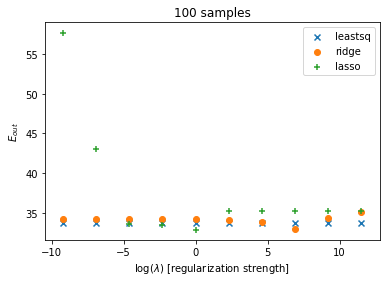

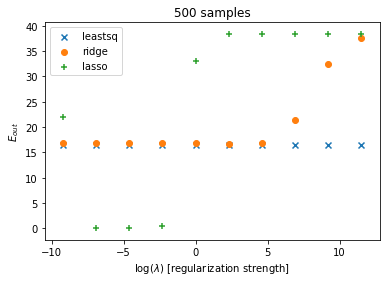

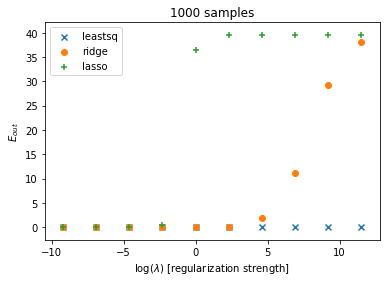

In [16]:
plot_ising_error('100 samples', ising(100, 40))
plot_ising_error('500 samples', ising(500, 40))
plot_ising_error('1000 samples', ising(1000, 40))

The best possible $E_{out}$ decreases drastically as a function of the number of samples for all methods. For ridge regression, the regularization strength should be sufficiently small (depending on the number of samples). For LASSO, there is an optimal value for the regularization strength, as the error does not behave monotonically. For the 500 samples it performs best among all methods, given that $\lambda\sim 10^{-5}$.